In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader
import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional, GRU
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented-all.csv

--2022-05-16 12:02:30--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5060506 (4.8M) [text/plain]
Saving to: ‘dev.csv’

dev.csv             100%[===================>]   4.83M  --.-KB/s    in 0.07s   

2022-05-16 12:02:31 (64.4 MB/s) - ‘dev.csv’ saved [5060506/5060506]

--2022-05-16 12:02:31--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40062185 (38M) [text/plain]
Saving

In [4]:
# Download
embedding_dim = 50
# glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dim}') # 50, 100, 200 or 300
glove_vectors = gensim.downloader.load(f'glove-twitter-{embedding_dim}') # 25, 50, 100, 200 or 300

[==================================================] 100.0% 199.5/199.5MB downloaded


# Data exploration

In [5]:
df = pd.read_csv("train.csv")
df = df.drop(["Unnamed: 0"],axis=1)

# df_aug = pd.read_csv("augmented.csv", sep='\t')
df_aug = pd.read_csv("augmented-all.csv", sep='\t')
df_aug['fraudulent'] = np.ones(len(df_aug), dtype=int)
df_aug = df_aug.replace(" ",np.nan)

df_val = pd.read_csv("dev.csv")
df_val = df_val.drop(["Unnamed: 0"],axis=1)

for df_column in df.columns:
    if df_column not in df_aug.columns:
        print("Dropped:", df_column)
        df = df.drop([df_column],axis=1)
        df_val = df_val.drop([df_column],axis=1)

df_aug.head()

Dropped: job_id
Dropped: company_profile


,title,location,department,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,salary_range,telecommuting,has_company_logo,has_questions,fraudulent
0,Client Audit coordinator Coordinator,"us, tx, austin",whole COMPLIANCE UNIT 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive ambit...,Full-time,NaN,Doctorate,financial intelligence,Administrative,NaN,NaN,NaN,NaN,1
1,national audit coordinator,"us, ny, ny",compliance COMPLIANCE UNIT 701,Description SUMMARY: The Client Audit Coordina...,high school diploma or equivalent; bachelor's ...,nurses offer a competitive relatively comprehe...,Full-time,NaN,Bachelor's Degree,fiscal Services,Engineering,NaN,NaN,NaN,NaN,1
2,node audit coordinator,"Austin TX, US,",701 UNIT COMPLIANCE,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive compa...,NaN,NaN,Bachelor's Degree,financial assistance,Other,NaN,NaN,NaN,NaN,1
3,client Audit Coordinator,"US, TX, capital of texas",compliance package 10,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive range...,NaN,NaN,High School or equivalent,fiscal Financial Services,Engineering,NaN,NaN,NaN,NaN,1
4,Client scrutinize Coordinator,"US, TX, Austin",COMPLIANCE UNIT compliance 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,We offer in competitive and evaluation typical...,NaN,Entry level,NaN,financial services,NaN,NaN,NaN,NaN,NaN,1


#### Missing Values

In [6]:
df_fake = df.loc[df["fraudulent"]==1]
df_true = df.loc[df["fraudulent"]==0]

In [7]:
def getNaNRatio(dataframes, column_names):
    nan_df = pd.DataFrame({
        'features': [column for column in sorted(dataframes[0].columns)]
    })
    for i in range(len(column_names)):
        dataframe = dataframes[i]
        rows = len(dataframe)
        nan_df[column_names[i]] = [round(dataframe[column].isna().sum()/rows, 20) for column in sorted(dataframe.columns)]

    return nan_df

In [8]:
getNaNRatio([df_fake, df_aug, df_true], ['Fake data', 'Fake data augmented', 'True data'])

,features,Fake data,Fake data augmented,True data
0,benefits,0.404402,0.404680,0.401561
1,department,0.610729,0.610461,0.645577
2,description,0.001376,0.002753,0.000000
3,employment_type,0.280605,0.277908,0.191795
4,fraudulent,0.000000,0.000000,0.000000
5,function,0.385144,0.378114,0.360831
6,has_company_logo,0.000000,1.000000,0.000000
7,has_questions,0.000000,1.000000,0.000000
8,industry,0.317744,0.317275,0.273919
9,location,0.019257,0.019270,0.019224


#### Correlation (features with binary value)

In [9]:
# Correlation
df[["telecommuting","fraudulent"]].corr()

,telecommuting,fraudulent
telecommuting,1.00000,0.03296
fraudulent,0.03296,1.00000


In [10]:
df[["has_company_logo","fraudulent"]].corr()

,has_company_logo,fraudulent
has_company_logo,1.000000,-0.264599
fraudulent,-0.264599,1.000000


-0.26 is significant correlation for keeping this feature

In [11]:
df[["has_questions","fraudulent"]].corr()

,has_questions,fraudulent
has_questions,1.000000,-0.092613
fraudulent,-0.092613,1.000000


# Preprocessing

## Fill nan

In [12]:
df = df.fillna("none")
df_aug = df_aug.fillna("none")
df_val = df_val.fillna("none")

## Concatenate Train and Augmented datasets

In [13]:
print('Train dataset length:', len(df))
print('Augmented dataset length:', len(df_aug))

df = pd.concat([df_aug, df])
df = shuffle(df)
df = df.reset_index()

print('Train dataset after concatenation:', len(df))

Train dataset length: 14304
Augmented dataset length: 14530
Train dataset after concatenation: 28834


## Merge Features

In [14]:
def merge(df):
    # df = df.assign(merged_features=lambda df: df["title"]+" "+df["location"]+" "+df["department"]+
    #           df["employment_type"]+" "+df["required_experience"]+" "+df["required_education"]+" "+
    #            df["industry"]+" "+df["function"])
    
    # df = df.assign(merged_features=lambda df: df["description"])
    
    df = df.assign(merged_features=lambda df: 
                   df["title"]+" "
                   +df["location"]+" "
                   +df["department"]+" "
                   +df["description"]+" "
                  #  +df["employment_type"]+" "
                  #  +df["required_experience"]+" "
                  #  +df["required_education"]+" "
                  #  +df["industry"]+" "
                  #  +df["function"]+" "
                  #  +df["requirements"]+" "
                  #  +df["benefits"]
                   )
    

    return df[["merged_features","fraudulent"]]

In [15]:
df_merged = merge(df)
df_val_merged = merge(df_val)
df_merged.head()

,merged_features,fraudulent
0,"Operations Manager US, DC, Washington none DBC...",0
1,"deputy supervisor US, TX, Houston none Oversee...",1
2,"Sales Professional- SMB (Full-Time) US, MD, ba...",1
3,"Regional Sales Manager US, MN, Minneapolis non...",0
4,"8th Grade Science Teacher US, NY, Albany none ...",0


In [16]:
features_train = np.array(df_merged["merged_features"])
target_train = np.array(df_merged["fraudulent"])

features_val = np.array(df_val_merged["merged_features"])
target_val = np.array(df_val_merged["fraudulent"])

## Tokenization

In [17]:
# Lowercase, removing stop words, punctuation, numbers, stemming

# Input -> array of docs
def preprocess_texts(texts):
    preprocessed = []
    # stop_words = stopwords.words('english')
    punct=string.punctuation
    # stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    print("Preprocessing..")
    for text in tqdm(texts):
        words = word_tokenize(text)
        words = [''.join([i for i in word if not i.isdigit()]) for word in words] # Removing numbers
        # All in one :)
        # words = [lemmatizer.lemmatize(word.lower()) for word in words if (word not in stop_words) and (word not in punct)]
        words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in punct]
        preprocessed.append(words)
        
    print("Done")
    return preprocessed
        

In [18]:
preprocessed_train = preprocess_texts(features_train)
preprocessed_val = preprocess_texts(features_val)
#print(preprocessed[:3])

Preprocessing..


100%|██████████| 28834/28834 [00:59<00:00, 481.25it/s]


Done
Preprocessing..


100%|██████████| 1788/1788 [00:03<00:00, 484.75it/s]

Done


## GloVe Embeddings

In [19]:
def texts2embeddings(texts, max_length, em_dim):
    zero_vector = np.zeros(em_dim)
    embeddings = []
    total_words = 0
    missing_words = 0
    for text in tqdm(texts):
        embedded_text = []
        for word in text:
            total_words += 1
            try:
                embedded_text.append(glove_vectors[word])
            except:
                # embedded_text.append(zero_vector)
                embedded_text.append(glove_vectors['unk'])
                missing_words += 1
        embeddings.append(embedded_text)
    embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post',value=zero_vector,dtype="float32")
    print("Missing words:",missing_words/total_words)
    return embeddings

In [20]:
max_input_length = max([len(doc) for doc in preprocessed_train]) 
print("Max length:", max_input_length)
max_input_length=1000

embedded_features_train = texts2embeddings(preprocessed_train,max_input_length,embedding_dim)
embedded_features_val = texts2embeddings(preprocessed_val,max_input_length,embedding_dim)

Max length: 1313


100%|██████████| 28834/28834 [00:08<00:00, 3532.24it/s]


Missing words: 0.05046605123429707


100%|██████████| 1788/1788 [00:00<00:00, 3748.92it/s]


Missing words: 0.05543104918272393


*Uncomment next cells if session crashes in colab:*

In [21]:
# with open('embedded_features_train.npy', 'wb') as f:
#     np.save(f, embedded_features_train)
# with open('embedded_features_val.npy', 'wb') as f:
#     np.save(f, embedded_features_val)

In [22]:
# with open('embedded_features_train.npy', 'rb') as f:
#     embedded_features_train = np.load(f)
# with open('embedded_features_val.npy', 'rb') as f:
#     embedded_features_val = np.load(f)

# Training the Neural Network

In [23]:
from functools import lru_cache
# Building model

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model = Sequential()
model.add(Bidirectional(LSTM(300, input_shape=(max_input_length, embedding_dim))))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(1,activation="sigmoid")) 
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(embedded_features_train, target_train, epochs=30, batch_size=32, verbose=2,
                    validation_data=(embedded_features_val,target_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
902/902 - 114s - loss: 0.3166 - accuracy: 0.8611 - val_loss: 0.2558 - val_accuracy: 0.8898 - 114s/epoch - 126ms/step
Epoch 2/30
902/902 - 108s - loss: 0.1170 - accuracy: 0.9569 - val_loss: 0.1191 - val_accuracy: 0.9592 - 108s/epoch - 120ms/step
Epoch 3/30
902/902 - 107s - loss: 0.0770 - accuracy: 0.9716 - val_loss: 0.1321 - val_accuracy: 0.9536 - 107s/epoch - 119ms/step
Epoch 4/30
902/902 - 108s - loss: 0.0530 - accuracy: 0.9806 - val_loss: 0.1048 - val_accuracy: 0.9754 - 108s/epoch - 119ms/step
Epoch 5/30
902/902 - 108s - loss: 0.0291 - accuracy: 0.9899 - val_loss: 0.1203 - val_accuracy: 0.9704 - 108s/epoch - 120ms/step
Epoch 6/30
902/902 - 108s - loss: 0.0249 - accuracy: 0.9918 - val_loss: 0.1413 - val_accuracy: 0.9636 - 108s/epoch - 120ms/step
Epoch 7/30
902/902 - 108s - loss: 0.0188 - accuracy: 0.9929 - val_loss: 0.1142 - val_accuracy: 0.9709 - 108s/epoch - 120ms/step
Epoch 8/30
902/902 - 108s - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.1375 - val_accuracy: 0.9709 - 

In [24]:
print("Baseline:",(1-sum(target_val)/len(target_val)))

Baseline: 0.9619686800894854


In [25]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

predicted = model.predict(embedded_features_val)
max_score = 0
max_threshold = None
max_threshold_predicted_labels = []

# As labels
for threshold in np.linspace(0.1, 0.9, 9):
    predicted_labels = []
    for p in predicted:
        if p >= threshold:
            predicted_labels.append([1])
        else:
            predicted_labels.append([0])


    f1_binary = f1_score(target_val,predicted_labels,average="binary")
    if f1_binary > max_score:
        max_threshold = threshold
        max_score = f1_binary
        max_threshold_predicted_labels = predicted_labels

print("Max threshold", max_threshold)
print("Accuracy:",accuracy_score(target_val, max_threshold_predicted_labels))
print("F1:")
print("Micro:",f1_score(target_val,max_threshold_predicted_labels,average="micro"))
print("Macro:",f1_score(target_val,max_threshold_predicted_labels,average="macro"))
print("Weighted:",f1_score(target_val,max_threshold_predicted_labels,average="weighted"))
print("For fraudulent:",f1_score(target_val,max_threshold_predicted_labels,average="binary"))

Max threshold 0.9
Accuracy: 0.9848993288590604
F1:
Micro: 0.9848993288590604
Macro: 0.880712522516512
Weighted: 0.9837146793554647
For fraudulent: 0.7692307692307692


Seems gooood!=)

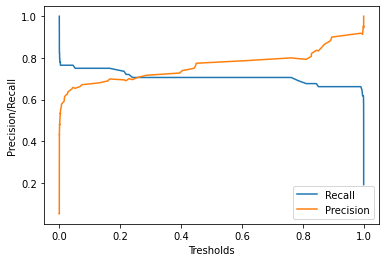

In [26]:
# Presicion / recall curve
precision,recall,tresholds = precision_recall_curve(target_val,predicted)

plt.plot(tresholds,recall[:-1],label="Recall")
plt.plot(tresholds,precision[:-1],label="Precision")
plt.xlabel("Tresholds")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

In [27]:
df_val['fraudulent'].value_counts(), sum(predicted >= max_threshold), sum(predicted < max_threshold)

(0    1720
 1      68
 Name: fraudulent, dtype: int64, array([49]), array([1739]))

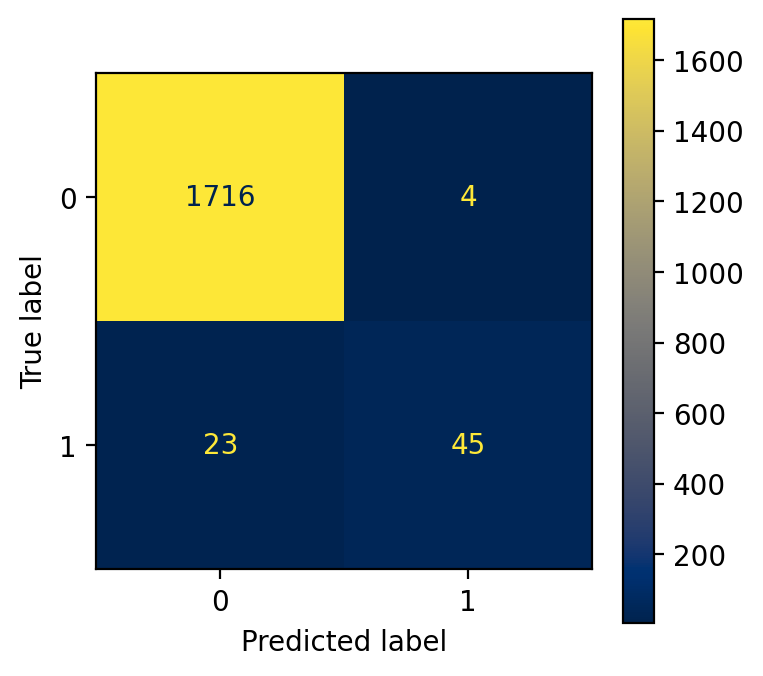

In [28]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(target_val, max_threshold_predicted_labels)).plot(cmap='cividis', ax=ax)
plt.show()

# Training Classical ML Models